# Assignment 2

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2021, Utrecht University*

Total points: 9 + 1 bonus (+ 1 for free)

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

## Coin Flipping
In this second assignment, you're going to see how some of the central concepts from Bayesian machine learning behave in different scenarios. You'll be looking at the coin flipping example that has also taken a central place in the book and the lectures so far.

When flipping a coin $N$ times, under very reasonable assumptions, the probability of getting $y$ times heads is given by the binomial distribution with parameters $N$ and $r$, where $r$ is the probability that the coin lands heads on one flip.

SciPy includes functions for working with many well-known distributions, allowing you to sample from them and compute probabilities and densities, as well as many other properties. For the binomial distribution, you can compute the probability of getting $y$ heads with `binom.pmf(y, N, r)`.

**Task 1** (1 point): For the values $r = 0.0, 0.01, \ldots, 1.0$, compute the likelihood of seeing 9 out of 10 heads, and plot these in a graph.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import beta as beta_dist
import scipy.special as sps
import random


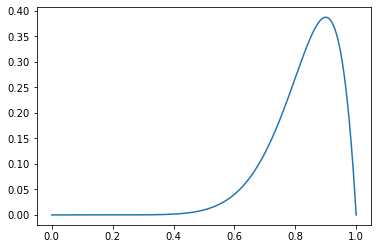

In [2]:
# Use np.linspace to get a NumPy array of evenly spaced values for r.
r_vals = np.linspace(0, 1, 1000)
probabilities = np.zeros_like(r_vals)

N = 10
y = 9

for idx, r in enumerate(r_vals):
    current_prob = binom.pmf(y, N, r)
    probabilities[idx] = current_prob

plt.plot(r_vals, probabilities)
plt.show();

### Predictors

We will define three different "predictor" classes. The first will use maximum likelihood to make its predictions, the other two will use a Bayesian approach, with different kinds of priors. Each predictor object will have the following functions:

* `predictor.update(num_heads, N)` returns a new predictor object. This predictor object takes into account that `N` new data points have been seen, `num_heads` of which were heads.

* `predictor.predict()` returns a number between 0 and 1, which is the probability that this predictor assigns to the next coin flip coming up heads.

* `predictor.marginal_likelihood(num_heads, N)` returns the Bayesian marginal likelihood. This is only defined for Bayesian predictors; for other types, it returns `np.nan` ("not a number").

The definition of the `MaximumLikelihoodPredictor` predictor class is given below (you don't need to change it), with some testing code to see it in action.

In [3]:
class MaximumLikelihoodPredictor:
    def __init__(self):
        self.num_heads = 0
        self.N = 0
    def __str__(self):
        return f"MaxiLikeliPredctr with num_heads = {self.num_heads}, N = {self.N}"
    def update(self, num_heads, N):
        after = MaximumLikelihoodPredictor()
        after.num_heads += num_heads
        after.N += N
        return after
    def predict(self):
        return self.num_heads / self.N
    def get_marginal_likelihood(self, num_heads, N):
        return np.nan

# ██████████ TEST ██████████
predictor = MaximumLikelihoodPredictor()
print("Before:", predictor)
# After two flips, both heads, you should get:
# After: MaximumLikelihoodPredictor with num_heads = 2, N = 2
# which should predict that the next flip will land heads with probability 1.0
predictor_after = predictor.update(2, 2)
print("After:", predictor_after)
print("prediction =", predictor_after.predict())

Before: MaxiLikeliPredctr with num_heads = 0, N = 0
After: MaxiLikeliPredctr with num_heads = 2, N = 2
prediction = 1.0


The two Bayesian predictor classes will be defined next. The first will use a discrete prior: instead of considering the entire range from 0 to 1 (containing infinitely many numbers) as possible values for $R$, it will only consider some finite set of such numbers. It assigns some probability to each of them, and these probabilities add up to 1. This finite set and the associated probabilities can be represented in Python by a dictionary, that maps a value $r$ to the probability assigned to it by the prior. For example, `prior.probability_for_r[.5] = .2` means that $P(R = .5) = .2$.

Being a Bayesian predictor, the `update` function will use Bayes' theorem to compute the posterior distribution after having seen the data. For a discrete prior, the posterior will assign probability to the same values $r$, but the probability assigned may be different.

**Task 2** (1 point): Complete the implementation of the `update` function below. (You'll finish to other incomplete functions in later tasks.) You can use the provided testing code to see if the posterior looks as it should.

In [4]:
class DiscretePriorPredictor:
    def __init__(self):
        self.probability_for_r = {}
    def __str__(self):
        return ("DiscrtPriorPredctr with "
                + "; ".join([f"P(R = {r:.4f}) = {prior_prob:.4f}"
                             for r, prior_prob in self.probability_for_r.items()]))
    def update(self, num_heads, N):
        if not len(self.probability_for_r):
            raise ValueError("assign probabilities for DiscretePriorPredictor before calling update")

        posterior = DiscretePriorPredictor()
        total_prob = 0.0
        for r, prior_prob in self.probability_for_r.items():
            # Compute the value in the numerator of Bayes' theorem, and
            # assign it to posterior.probability_for_r[r]
            numerator = binom.pmf(num_heads, N, r) * self.probability_for_r[r]
            posterior.probability_for_r[r] = numerator
            total_prob += numerator

        # Finaly, divide everything by the sum
        for r, posterior_prob in posterior.probability_for_r.items():
            posterior.probability_for_r[r] = np.float64(posterior.probability_for_r[r]) / np.float64(total_prob)
        return posterior
    def predict(self):
        if not len(self.probability_for_r):
            raise ValueError("assign probabilities for DiscretePriorPredictor before calling predict")

        summed_prob = 0
        for r, prob in self.probability_for_r.items():
            summed_prob += r * prob
        return summed_prob
    def get_marginal_likelihood(self, num_heads, N):
        if not len(self.probability_for_r):
            raise ValueError("assign probabilities for DiscretePriorPredictor before calling get_marginal_likelihood")

        marginal_sum = 0
        for r in self.probability_for_r.keys():
            marginal_sum += binom.pmf(num_heads, N, r) * self.probability_for_r[r]
        return marginal_sum

# ██████████ TEST ██████████
discrete_prior = DiscretePriorPredictor()
discrete_prior.probability_for_r[1/3] = 1/2
discrete_prior.probability_for_r[2/3] = 1/2
print("Prior:", discrete_prior)
# After two flips, both heads, you should get:
# Posterior: DiscretePrior with P(R = 0.3333) = 0.2000; P(R = 0.6667) = 0.8000,
# which should predict that the next flip will land heads with probability 0.6.
# The marginal likelihood for these data and prior should be ~ 0.2777.
discrete_posterior = discrete_prior.update(2, 2)
print("Posterior:", discrete_posterior)
print("prediction =", discrete_posterior.predict())
print("marginal likelihood =", discrete_prior.get_marginal_likelihood(2, 2))

Prior: DiscrtPriorPredctr with P(R = 0.3333) = 0.5000; P(R = 0.6667) = 0.5000
Posterior: DiscrtPriorPredctr with P(R = 0.3333) = 0.2000; P(R = 0.6667) = 0.8000
prediction = 0.6
marginal likelihood = 0.27777777777777773


The Bayesian predictive distribution is the distribution over a new coin flip, conditioned on the data. Calling the `predict` function on the posterior should output the probability $P(\text{new flip = heads} | \text{previous data})$. You saw how to compute it on the final slide of lecture 5.

**Task 3** (1 point): Implement the `predict` function above.

Finally, the marginal likelihood is the quantity that occurs in the denominator of Bayes' Theorem. In this case, the prior is discrete, so the marginal likelihood is given by a sum.

The marginal likelihood is *not conditioned on the data*. In our code, the `posterior` object (computed by `update`) can tell us things that involve conditioning on the data. But for the marginal likelihood, we'll need to origina `prior` object. You'll see that the testing code calls `prior.get_marginal_likelihood`, not on `posterior.get_marginal_likelihood`.

**Task 4** (0.5 points): Implement the `get_marginal_likelihood` function above.

**Task 5** (1 point): Write a function that visualises a `DiscretePriorPredictor` using vertical lines whose height denotes the probability attached to some value of $r$: something like [this figure from Wikipedia](https://en.wikipedia.org/wiki/Discrete_uniform_distribution#/media/File:Uniform_discrete_pmf_svg.svg). Use `plt.vlines`. Set the horizontal axis to run from -0.05 to 1.05. Use your function to plot the prior and the posterior from the test code above.

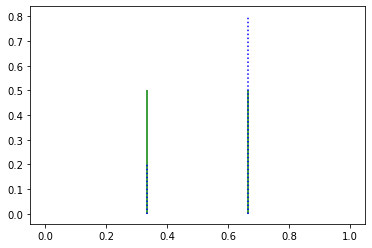

In [5]:
plt.vlines(discrete_prior.probability_for_r.keys(),
           [0 for _ in range(len(discrete_posterior.probability_for_r))],
           discrete_prior.probability_for_r.values(),
           color='green')
plt.vlines(discrete_posterior.probability_for_r.keys(),
           [0 for _ in range(len(discrete_posterior.probability_for_r))],
           discrete_posterior.probability_for_r.values(),
           color='blue', linestyles='dotted')

plt.xlim(-0.05, 1.05);
plt.show()

The final predictor class will use the Beta distribution. This is a continuous prior that considers all values of $r$ between 0 and 1. It is the conjugate prior for the binomial likelihood, which has some major computational advantages.

**Task 6** (1 point): Implement `update` and `predict` below for the `BetaPriorPredictor`.

In [6]:
class BetaPriorPredictor:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    def __str__(self):
        return f"BetaPriorPredctr with alpha = {self.alpha:.4f}, beta = {self.beta:.4f}"
    def update(self, num_heads, N):
        # We need alpha and beta for the beta dist.
        a = self.alpha + num_heads
        b = self.beta + (N - num_heads)
        return BetaPriorPredictor(a, b)
    def predict(self):
        return (self.alpha / (self.alpha + self.beta)) # Expected value of beta dist
    def get_marginal_likelihood(self, num_heads, N):
        if self.alpha < 1e-9 or self.beta < 1e-9:
            return np.nan
        # The Gamma function may output really large numbers. To avoid
        # numerical inaccuracy, the following code works with logarithms instead,
        # converting back to the actual number when all Gamma's have been combined.
        return (#math.comb(N, num_heads) # since version 3.8
                sps.binom(N, num_heads)
                * math.exp(math.lgamma(self.alpha + self.beta)
                           - math.lgamma(self.alpha)
                           - math.lgamma(self.beta)
                           + math.lgamma(self.alpha + num_heads)
                           + math.lgamma(self.beta + N - num_heads)
                           - math.lgamma(self.alpha + self.beta + N)
                          )
               )
    
# ██████████ TEST ██████████
beta_prior = BetaPriorPredictor(1, 1)
print("Prior:", beta_prior)
# After two flips, both heads, you should get:
# Posterior: BetaPrior with alpha = 3.0000, beta = 1.0000
# which should predict that the next flip will land heads with probability 0.75
# The marginal likelihood for these data and prior should be ~ 0.3333.
beta_posterior = beta_prior.update(2, 2)
print("Posterior:", beta_posterior)
print("prediction =", beta_posterior.predict())
print("marginal likelihood =", beta_prior.get_marginal_likelihood(2, 2))

Prior: BetaPriorPredctr with alpha = 1.0000, beta = 1.0000
Posterior: BetaPriorPredctr with alpha = 3.0000, beta = 1.0000
prediction = 0.75
marginal likelihood = 0.3333333333333331


**Task 7** (0.5 points): Write a function that visualises a `BetaPriorPredictor` by plotting its probability density function. You can use the `beta` object from `scipy.stats`, which has already been imported. Use your function to plot the prior and the posterior from the test code above.

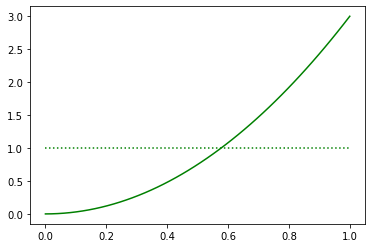

In [7]:
plotting_r_7 = np.linspace(10**-4, 1-(10**-4))

plt.plot(plotting_r_7,
         beta_dist.pdf(plotting_r_7,
                       beta_posterior.alpha,
                       beta_posterior.beta),
         color='green');
plt.plot(plotting_r_7, 
         beta_dist.pdf(plotting_r_7,
                       beta_prior.alpha,
                       beta_prior.beta),
         linestyle='dotted',
         color='green');

**Question 8** (0.5 points): For what values of alpha and beta does the Beta distribution have the same shape as the likelihood you plotted in task 1? Explain your answer, and verify it by showing the plot.

**Answer:** The shape of the liklihood is the same for $\alpha=10,\beta=2$. That's because for those values, we 'update' the intial prior to look just like the prior we had in 1. (The current distribution has now become the same as immediately initalising it with those values.)

Posterior: BetaPriorPredctr with alpha = 10.0000, beta = 2.0000


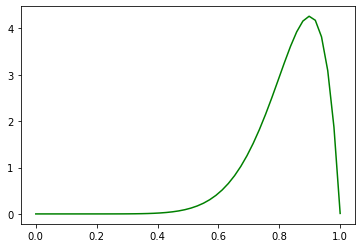

In [8]:
beta_prior_8 = BetaPriorPredictor(1+9,1+1)
print("Posterior:", beta_prior_8)

plotting_r_8 = np.linspace(10**-4, 1-(10**-4))
plt.plot(plotting_r_8,
         beta_dist.pdf(plotting_r_8,
                       beta_prior_8.alpha,
                       beta_prior_8.beta),
         color='green');

### Experimenting with different predictors

Next, we want to see the predictors in action. First, the code below creates a list of ten predictors, using the three classes defined above. We'll investigate their behaviour on several different values of the true probability of getting heads. These probabilities are defined below by `true_rs = [0, .3, .5, 2/3, .75, .999]`.

Note that the final predictor in the list, `BetaPriorPredictor(0, 0)`, doesn't satisfy the constraints for being a proper Beta prior: that requires $\alpha > 0$ and $\beta > 0$. The problem is in the normalisation constant, which is undefined in this case. As we've seen, we can often get away with ignoring the normalisation constant, and by carrying this a bit further, we can use this unnormalised distribution as a prior in Bayes' theorem. Such a thing is called a *degenerate prior*. Often (but not always), the posterior we find will be a proper distribution again.

In [9]:
# Create a list of predictors to be compared.
predictors = [MaximumLikelihoodPredictor()]

prior = DiscretePriorPredictor()
prior.probability_for_r[1/3] = 1/2
prior.probability_for_r[2/3] = 1/2
predictors.append(prior)

prior = DiscretePriorPredictor()
prior.probability_for_r[1/3] = 1/3
prior.probability_for_r[1/2] = 1/3
prior.probability_for_r[2/3] = 1/3
predictors.append(prior)

prior = DiscretePriorPredictor()
prior.probability_for_r[0] = 1/2
prior.probability_for_r[1] = 1/2
predictors.append(prior)

prior = DiscretePriorPredictor()
for r in np.linspace(0, 1, 11):
    prior.probability_for_r[r] = 1/11
predictors.append(prior)

prior = DiscretePriorPredictor()
for r in np.linspace(0, 1, 101):
    prior.probability_for_r[r] = 1/101
predictors.append(prior)

prior = BetaPriorPredictor(1, 1)
predictors.append(prior)

prior = BetaPriorPredictor(3, 3)
predictors.append(prior)

prior = BetaPriorPredictor(.5, .5)
predictors.append(prior)

prior = BetaPriorPredictor(0, 0)
predictors.append(prior)

true_rs = [0, .3, .5, 2/3, .75, .999]

For each combination of a predictor and a value $r_\text{true}$ from `true_rs`, we will sample some training data (say 100 coin flips) and compute an updated predictor using these data. For the Bayesian predictors, this comes down to computing the posterior distribution. Then we'll sample some test data, say 100 points again. For both the training and the test data, the true probability of getting heads on each flip is given by $r_\text{true}$.

Now we want to evaluate how well the predictor does at predicting the test data. There are several ways to measure this. We'll try two different ones: the *logarithmic loss* and the *logarithmic regret*.

The **logarithmic loss** is something you may have seen before in other places. For instance, logistic regression is training to minimise this loss, and it's also one of the most popular choices when training neural networks for binary classification problems (there you may have seen it under the name "cross entropy"). Suppose the predictor assigns probability $\hat{r}$ to the outcome heads for a new coin flip $Y_\text{new}$, and that a new flip actually comes out as $y_\text{new}$ (1 for heads, 0 for tails). Then the logarithmic loss of this prediction is
$$-\log P_{\hat{r}} ( Y_\text{new} = y_\text{new} ).$$
In other words, if the coin in the test data came up heads, the loss is $-\log (\hat{r})$; if it came up tails, the loss is $-\log (1 - \hat{r})$.

The logarithm of 1 is 0, and as $x$ goes down to $0$, $\log(x)$ goes down to $-\infty$. So we see that the logarithmic loss is a small positive number if the outcome of the test data point was something the predictor thought was probably going to happen. But if something happens that the predictor thought would happen only with a small probability, the logarithmic loss will be larger.

Implementation note: because the logarithm of 0 is minus infinity, write your code in such a way that if no flip happened for which the predicted probability was 0, then $\log(0)$ isn't called.

One issue with logarithmic loss (or any loss, for that matter) is, that it's easier for predictors to get low average losses if $r_\text{true}$ is close to 0 or 1, but much harder if it's closer to 0.5. To make the comparison more fair, we can look at the **regret** corresponding to the loss, so logarithmic regret in our case. The regret equals the loss of a predictor *minus* the loss of an ideal predictor that already knew the value $r_\text{true}$. In other words, the ideal predictor uses $r_\text{true}$ in the place where other predictors use $\hat{r}$. By comparing our predictor's loss to the loss even a clairvoyant predictor would obtain, we'll get numbers that are more meaningful when different values of $r_\text{true}$ are involved.

**Task 9** (1.5 points): For each combination of predictor and $r_\text{true}$, repeat this process 100 times (including getting new training and new test data every time), and store the following in three NumPy arrays:

* The average loss;

* The average regret;

* The average marginal likelihood of the *training data* (don't use the test data for this one!)

In [10]:
N_train = 100
N_test = 100
N_iter = 100

losses = np.full((len(true_rs), len(predictors), N_iter), None)
regrets = np.full((len(true_rs), len(predictors), N_iter), None)
likelihoods = np.full((len(true_rs), len(predictors), N_iter), None)

# For each true r,
for r_idx, r_true in enumerate(true_rs):
    for prior_idx, prior in enumerate(predictors): # Consider each prior
        for N in range(N_iter): # Repeat the experiment N_iter times

            # Generate the data
            heads_train = np.random.binomial(N_train, r_true)
            heads_test = np.random.binomial(N_test, r_true)
            # Use it to update the prior
            posterior = prior.update(heads_train, N_train) #N or N_train
            # get r-hat after evidence was observed
            r_hat = posterior.predict()

            # use r_hat and r_true to calculate the loss with respect to the test-set
            if   (r_hat == 1 and heads_test == N_test):   curr_loss = (heads_test) * -1 * np.log(r_hat)                  # r_hat = 1 & only heads
            elif (r_hat == 1 and heads_test != N_test):   curr_loss = np.inf                                             # r_hat = 1 & not only heads
            elif (r_hat == 0 and heads_test == 0):        curr_loss = (N_test - heads_test) * -1 * np.log(1 - r_hat)     # r_hat = 0 & only tails
            elif (r_hat == 0 and heads_test != 0):        curr_loss = np.inf                                             # r_hat = 0 & not only tails
            else: curr_loss = (heads_test) * -1 * np.log(r_hat) + (N_test - heads_test) * -1 * np.log(1 - r_hat)

            # de regret is nu loss_rhat - loss_rtrue
            if   (r_true == 1 and heads_test == N_test):  curr_true_loss = (heads_test) * -1 * np.log(r_true)
            elif (r_true == 1 and heads_test != N_test):  curr_true_loss = np.inf
            elif (r_true == 0 and heads_test == 0):       curr_true_loss = (N_test - heads_test) * -1 * np.log(1 - r_true)
            elif (r_true == 0 and heads_test != 0):       curr_true_loss = np.inf
            else: curr_true_loss = (heads_test) * -1 * np.log(r_true) + (N_test - heads_test) * -1 * np.log(1 - r_true)

            # calculate the regret loss
            curr_regret = curr_loss - curr_true_loss
            # calculate the marginal likelihood
            curr_likelihood = prior.get_marginal_likelihood(heads_train, N_train)

            # Save the losses, regrets and marginal liklihoods (in order to calculate their mean)
            losses[r_idx, prior_idx, N] = curr_loss
            regrets[r_idx, prior_idx, N] = curr_regret
            likelihoods[r_idx, prior_idx, N] = curr_likelihood

C:\Users\DK\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
def printStr(FloatNumber, Precision):
    return "%0.*f" % (Precision, FloatNumber)

In [12]:
l_df = pd.DataFrame(np.mean(losses, axis = 2),
             index = [printStr(r, 3) for r in true_rs], 
             columns = [str(a).split(' ', 1)[0] for a in predictors])
l_df.transpose()

,0.000,0.300,0.500,0.667,0.750,0.999
MaxiLikeliPredctr,-0,61.619,69.6941,64.3595,56.6721,inf
DiscrtPriorPredctr,40.5465,61.2993,74.064,63.864,57.6118,40.6366
DiscrtPriorPredctr,40.5465,61.7074,69.7335,63.9137,57.7525,40.6228
DiscrtPriorPredctr,-0,NaN,NaN,NaN,NaN,NaN
DiscrtPriorPredctr,0.000265611,61.6009,69.8104,64.7561,57.3301,2.46401
DiscrtPriorPredctr,0.568574,61.1149,70.0465,64.3485,56.731,1.28086
BetaPriorPredctr,0.98523,61.6534,70.0097,64.4312,56.3906,1.4989
BetaPriorPredctr,2.87101,61.9979,69.7018,64.3545,56.5267,3.36676
BetaPriorPredctr,0.496279,61.7074,69.8535,63.8822,56.6175,1.14661
BetaPriorPredctr,-0,61.3535,69.7362,64.4125,56.7035,inf


In [13]:
r_df = pd.DataFrame(np.mean(regrets, axis = 2),
             index = [printStr(r, 3) for r in true_rs], 
             columns = [str(a).split(' ', 1)[0] for a in predictors]).round(1)
r_df.transpose()

,0.000,0.300,0.500,0.667,0.750,0.999
MaxiLikeliPredctr,0,0.422444,0.379382,0.835147,0.471519,inf
DiscrtPriorPredctr,40.5465,0.263745,4.74929,-5.0637e-07,1.79575,39.6387
DiscrtPriorPredctr,40.5465,0.197291,0.418751,0.153722,1.71673,39.763
DiscrtPriorPredctr,0,NaN,NaN,NaN,NaN,NaN
DiscrtPriorPredctr,0.000265611,0.548328,0.495721,0.483136,0.448404,1.60421
DiscrtPriorPredctr,0.568574,0.486023,0.731804,0.366694,0.47549,0.352001
BetaPriorPredctr,0.98523,0.482238,0.694948,0.594954,0.266946,0.777244
BetaPriorPredctr,2.87101,0.64885,0.387045,0.476616,0.315154,2.36883
BetaPriorPredctr,0.496279,0.299005,0.538782,0.517285,0.526767,0.355885
BetaPriorPredctr,0,0.572053,0.421502,0.583171,0.788617,inf


In [14]:
lk_df = pd.DataFrame(np.mean(likelihoods, axis = 2), 
             index = [printStr(r, 3) for r in true_rs], 
             columns = [str(a).split(' ', 1)[0] for a in predictors])
lk_df.transpose()

,0.000,0.300,0.500,0.667,0.750,0.999
MaxiLikeliPredctr,NaN,NaN,NaN,NaN,NaN,NaN
DiscrtPriorPredctr,1.22983e-18,0.0280742,0.00325072,0.0303582,0.0142947,2.12576e-17
DiscrtPriorPredctr,8.19885e-19,0.0170564,0.0216698,0.0208027,0.00898477,3.63209e-18
DiscrtPriorPredctr,0.5,0,0,0,0,0.475
DiscrtPriorPredctr,0.0909115,0.00903225,0.0090073,0.00903628,0.00896276,0.0800066
DiscrtPriorPredctr,0.0155655,0.00980296,0.00980296,0.00980296,0.00980296,0.0151145
BetaPriorPredctr,0.00990099,0.00990099,0.00990099,0.00990099,0.00990099,0.00990099
BetaPriorPredctr,5.33447e-05,0.0128259,0.0178762,0.0141058,0.0107185,5.74868e-05
BetaPriorPredctr,0.0563485,0.00693952,0.00636906,0.00678045,0.00736393,0.0529846
BetaPriorPredctr,NaN,NaN,NaN,NaN,NaN,NaN


**Question 10** (1 point + 1 bonus point): Now analyse the results of your experiment. Answer at least the following questions:

* For each combination of predictor and $r_\text{true}$ that gives `inf` or `nan` loss, explain why the total loss isn't finite.

* What are the strengths and weaknesses of the different predictors? In a situation where you don't know anything about $r_\text{true}$ beforehand, which priors would you recommend, and which not?

* BONUS: Look at the marginal likelihoods, say something about model selection

You can accompany your answer by additional code that produces tables or figures.

**Answer 1:** When collapsing the **N** repeats in the 3rd dimensions into a 2 dimensional matrix, if there is a single entry in the repeat vector that is **Inf**, all values in the nominator of the average will be added to **Inf**, hence the mean of the third dimension will also be **Inf** in the 2 dimensional matrix. Since that's calculated as: $\frac{1}{N}\Sigma \text{ losses}$. Infinity + something and then divided by N is still infinity. The same is true for NaNs.

An entry in the repeat vector gets **Inf** in the cases of **r_hat** = 0 of **r_hat** = 1, and if a generate flip does not precisely match this probability of the coin. However, this is entirely possible, since the data is drawn from a binomial distribution, based on **r_true**. In the calculation of the loss, the log of **r_hat** = 0 or **r_hat** = 1, will result in **-Inf**; when multiplied with -1, will be **Inf** and adding the second term will be, for most values of the second term (e.g. not -infinite), still **Inf**. Hence the loss will be **Inf** for that **r_hat**.

So, to restate, this occurs only if the predicted **r_hat** is either 0 or 1, *and* the generated test-data is not in accordance with that. For instance, not either only tails in the case of **r_hat** = 0; not only heads in the case of **r_hat** = 1.
&nbsp;  

**Answer 2: Predictability measure**. In answering this, we will keep in mind that we do not know anything about r_true. This means that it could be any value between 0 and 1.
* A problem with the MaximumLikelihoodPredictor and BetaPriorPredictor is that when we predict **r_hat** to be either 0 or 1, we are likely to get a prediction that is not useful. This means using this approach is prone to sampling errors. Because only when the **r_true** is exactly 0 or 1, we can get a prediction for **r_hat** that gives **Inf** loss, but also when **r_true** is just close to 0! Since the closer it is to 0, the higher the chance that the training-set will be such that we predict **r_hat** = 0 or 1. Like, in this example we used an **r_true** of exactly 0, but you can easily make a symmetry-argument, and also verify in this code (which we did!) that if you use an r-true of 0.01 you also get **Inf**.
* A disadvantage of the DiscretePriorPredictor is that it gives unusable predictions for one of the initialisations. As we will elaborate on a bit further, this could be avoided by (slightly) different initialisation.

The predictors could give Nan or Inf as prediction, which is neither useful for prediction nor does it correspond with real-life situations. However, all predictors, expect for the MaximumLiklihoodPredictor, can be initialized with different values of **r_hat** (thus different liklihoods for tails and heads), which are able to give reasonable values (or non-infinite and nan values). Thus, the discrete and the beta predictors with the overall lowest regret’s and largest marginals across all r, would be the most suitable priors. More specifically: 
* For instance DiscretePriorPredictor 2 has the lowest marginals for almost all values of **r_true**, expect for its most extreme values, which however are very unlikely, if not, realistically impossible to have in a two sided coin (e.g. that should been only one surface). The loss and regret are only very low (and applicable) for those extreme values. Similarly, its 'Beta-equivalent', BetaPriorPredictor 3, does a better job in fitting the prior to the data when **r_true** has ideal extreme values (the marginal liklihood is higher and the loss is lower for those values), while fitting less well for other values of r. When there are strong indications that **r_true** is ultimately biased (close to 0 or 1; hence not knowing the direction of the bias), both priors can representat this belief, with the BetaPriorPrediction 3 being somewhat off and the DiscretePriorPrediction 2 being not applicable, if there are no such strong a priori indications for extreme probability of **r_true**. Therefore, the BetaPriorPredictor 3 is preferred over the DiscretePriorPredictor 2, since it can make prediction for other values of r (they do not have to match exactly the most extreme values), albeit fitting the data less well than other prior beliefs.
* Unlike DiscretePriorPredictor 2, most models (thus expect for the homogenous ones and the 3 DiscretePriorPredictor) do not fit well when **r_true** has those ideal extreme values (the marginal likelihood is very low at those values). The BetaPriorPredictor 2 is a roughly similar to a normal distribution, hence the marginal likelihood is the highest for intermediate values of **r_true** than for the extreme values. Similarly, the DescretePriorPrediction 1 and 2 fit the data well for the intermediate values of **r_true**, with an overall better performance in terms of data fit, loss and regret DescretePriorPrediction 2 (especially if the coin is fair) and a somewhat better performance for DescretePriorPrediction 1 when it is expected that **true_r** is slightly biased towards either side (1/3 and 2/3). Theoretically and realistically those priors could be considered the most reasonable ones, if the prior belief is that the coin is fair (eventually excluding DescretePriorPrediction 1) or when there is somewhat bias involved in any direction. They are not suitable if there are strong indications for heavy bias (BetaPriorPredictor 3 would be a better choice)
* The homogenous models (DiscretePriorPredictor 4 and 5 and BetaPriorPredictor 1) all fit the data equally bad, with very low marginal likelihood at every value of r. With respect to the model loss and marginal likelihood the DiscretePriorPredictors they tend to do better for **r_hat** having ideally extreme values of 0 and 1; DiscretePriorPredictor 4 has a ‘coarser’ distribution than 5 and tends to perform better.  This makes only sense when there is extremely limited knowledge about **r_true** whatsoever.
* The BetaPriorPredictor 4, can be theoretically and practically problematic, since it does satisfy the constraints for being a proper Beta prior. Although its numerical representations in loss and regret are comparable to the other models, the model fit to the data cannot be assesed, since this this degenerated prior lacks its normalizaion constant. There is uncertainty whether the posterior of the BetaPriorPredictor 4 becomes a proper distribution. This prior does not perform better than the others and given its drawbacks can better be avoided.

Concluding, the MaximumLiklihoodPredictor, DescretePriorPredictor 3 and BetaPriorPredictor are not recommended, while the usefulness of the other predictors depend on the belief of how strongly the coin is biased or fair, with DescretePriorPredictor 2 being the most recommended choice (unless there are strong beliefs that the coin is heavily biased, then the choice would fall on BetaPrior Prediction 3). Although if absolutely nothing is known about **r_true** (lacking any indication) the best choice might probably be the homogenous DiscretePriorPredictor 4.

    
---

<br>
<br>

**Remember: Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**<br/>
**Also remove our hints/comments from your code**